In [1]:
# import library and set up global parameters
import numpy as np
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import warnings
warnings.filterwarnings('ignore')

#data_path
data_path = "./data/day.csv"
seed = 1

In [2]:
def eleminate_upper_ouliers(data, columns, print_output = True):
    """
        Find outliers upper fence, value > Q3 + 1.5*IQR
        Input: Dataframe
        Output: Dataframe which eleminated outliers
    """
    df_quantile = data[columns].quantile([0.25, 0.75])
    Q1 = df_quantile[0.25]
    Q3 = df_quantile[0.75]
    IQR = Q3 - Q1
    upper_outlier = Q3+1.5*IQR
    
    ret_data = data[data[columns]<upper_outlier]
    
    # print some results
    if print_output:
        outliters = data[data[columns]>upper_outlier]
        print("Upper outliers of dataset:", upper_outlier)
        print("Num rows of outliers:", len(data) - len(ret_data))
        print("A look of boxplot after remove outliers")
        sns.boxplot(x = ret_data[columns])
        plt.plot()
    return ret_data, outliters

In [3]:
def plot_uni_numb(data, column, figsize=[20,10]):  
    plt.figure(figsize=figsize)

    # count number of category

    # firgue 1
    plt.subplot(1,3,1)
    sns.histplot(data = data[column])
    plt.title(("Histogram of" + column), fontsize=12)
    # firgue 2
    plt.subplot(1,3,2)
    sns.boxplot(data = data[column])
    plt.title("Box plot " + column, fontsize=12)
    # firgue 3
    plt.subplot(1,3,3)
    sns.boxplot(y = data[column], x= data['cnt'], palette = 'hls')
    plt.title("Box plot " + column, fontsize=12)


    plt.show()

In [4]:
def plot_bi_cate(data, column, figsize=[20,15], check_order = False):  
    plt.figure(figsize=figsize)

    if check_order:
        order = sorted(list(data[column].unique()))
    else:
        order = None

    plt.subplot(3,1,1)
    data[column].value_counts().plot.pie(autopct='%1.2f%%', shadow=True, startangle=90)
    plt.title(("Histogram of" + column), fontsize=12)

    plt.subplot(3,1,2)
    sns.countplot(x=data[column], order = order)
    plt.title(("Distribution of " + column), fontsize=12)

    plt.subplot(3,1,3)
    sns.barplot(x = data[column], y= data['cnt'], palette = 'hls', order = order)
    plt.title("Total rental bikes by " + column, fontsize=12)
    plt.show()

In [5]:
def linear_regression(X_train, y_train, X_test, y_test, print_summary = True, print_chart = True):
    """
        Linear regression model
    """
    X_train = sm.add_constant(X_train) # adding a constant
    model = sm.OLS(y_train, X_train).fit()
    X_test = sm.add_constant(X_test)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    print("R2 Score of the training data:",r2_score(y_pred = y_pred_train, y_true = y_train))
    print("R2 Score of the testing data:",r2_score(y_pred = y_pred_test, y_true = y_test))
    if print_summary:
        print(model.summary())
    if print_chart:
        sns.regplot(y_test,y_pred_test)
    return model

In [6]:
def get_pvalues(model):
  pval = pd.DataFrame(data= model.pvalues, columns=['Pvalue'])
  pval['feature'] = pval.index
  pval.reset_index(drop=True, inplace=True)
  pval['Pvalue'] = [round(i,3) for i in pval['Pvalue']]
  pval = pval[['feature','Pvalue']].sort_values('Pvalue', ascending=False)
  return pval

In [7]:
def get_VIF(X_train):
  columns = X_train.columns
  # VIF DataFrame
  vif_data = pd.DataFrame()
  vif_data["feature"] = X_train.columns
  # calculating VIF for each feature
  vif_data["VIF"] = [variance_inflation_factor(X_train[columns].values, i) for i in range(len(columns))]
  vif_data = vif_data.sort_values('VIF', ascending=False)
  return vif_data

# DATA VISUALIZATION 

## 1. Loading data

**Dictionary**
<ol>
    <li>instant: record index</li>
    <li>dteday : date</li>
    <li>season : season (1:spring, 2:summer, 3:fall, 4:winter)</li>
    <li>yr : year (0: 2018, 1:2019)</li>
    <li>mnth : month ( 1 to 12)</li>
    <li>holiday : weather day is a holiday or not</li>
    <li>weekday : day of the week</li>
    <li>workingday : if day is neither weekend nor holiday is 1, otherwise is 0.</li>
    <li>
        weathersit :
        <ul>
        <li>1: Clear, Few clouds, Partly cloudy, Partly cloudy - Clear</li>
        <li>2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist - Mist</li>
        <li>3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds - Light_Snow_Rain</li>
        <li>4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog - Heavy_Rain</li>
        </ul>
    </li>
    <li>temp : temperature in Celsius</li>
    <li>atemp: feeling temperature in Celsius</li>
    <li>hum: humidity</li>
    <li>windspeed: wind speed</li>
    <li>casual: count of casual users</li>
    <li>registered: count of registered users</li>
    <li>cnt: count of total rental bikes including both casual and registered</li>
</ol>

In [8]:
dateparse = lambda x: datetime.datetime.strptime(x, '%d-%m-%Y')
df = pd.read_csv(data_path, parse_dates=['dteday'], date_parser=dateparse)
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2018-01-01,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,2018-01-02,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,2018-01-03,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,2018-01-04,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,2018-01-05,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [9]:
# shape of data
df.shape

(730, 16)

In [10]:
# check non-null and types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     730 non-null    int64         
 1   dteday      730 non-null    datetime64[ns]
 2   season      730 non-null    int64         
 3   yr          730 non-null    int64         
 4   mnth        730 non-null    int64         
 5   holiday     730 non-null    int64         
 6   weekday     730 non-null    int64         
 7   workingday  730 non-null    int64         
 8   weathersit  730 non-null    int64         
 9   temp        730 non-null    float64       
 10  atemp       730 non-null    float64       
 11  hum         730 non-null    float64       
 12  windspeed   730 non-null    float64       
 13  casual      730 non-null    int64         
 14  registered  730 non-null    int64         
 15  cnt         730 non-null    int64         
dtypes: datetime64[ns](1), floa

In [11]:
# decribe data
df.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


**Remove**: from data under standing from dictionary, remove these columns, which are irrelavent

In [12]:
# instant: nothing to do with target
df.drop(['instant'], axis = 1, inplace = True)

# casual and registered: sum of them equal target
df.drop(['casual'], axis = 1, inplace = True)
df.drop(['registered'], axis = 1, inplace = True)

## 2. Cleaning data

In [13]:
# Trailing Spaces filter
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

### 2.1. Missing values

In [14]:
df.isnull().sum()

dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
dtype: int64

**Conclusion**: No missing value, no need to impute data

### 2.2. Dtypes

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   dteday      730 non-null    datetime64[ns]
 1   season      730 non-null    int64         
 2   yr          730 non-null    int64         
 3   mnth        730 non-null    int64         
 4   holiday     730 non-null    int64         
 5   weekday     730 non-null    int64         
 6   workingday  730 non-null    int64         
 7   weathersit  730 non-null    int64         
 8   temp        730 non-null    float64       
 9   atemp       730 non-null    float64       
 10  hum         730 non-null    float64       
 11  windspeed   730 non-null    float64       
 12  cnt         730 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(8)
memory usage: 74.3 KB


**Conclusion**: Dtypes good, no "object" type found. Can derive from dteday later

### 2.3. Outliers

In [16]:
# Unique values in all columns
df.nunique()

dteday        730
season          4
yr              2
mnth           12
holiday         2
weekday         7
workingday      2
weathersit      3
temp          498
atemp         689
hum           594
windspeed     649
cnt           695
dtype: int64

**Categorical Values**: season, yr, mnth, holiday, weekday, workingday, weathersit

**Continuous Variables**: Others (not check dteday)

##### temp

In [17]:
df["temp"].describe()

count    730.000000
mean      20.319259
std        7.506729
min        2.424346
25%       13.811885
50%       20.465826
75%       26.880615
max       35.328347
Name: temp, dtype: float64

<AxesSubplot:xlabel='temp'>

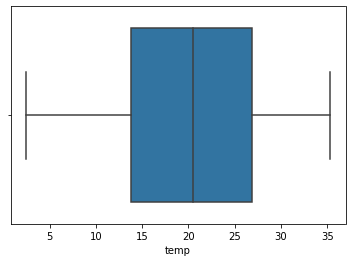

In [18]:
sns.boxplot(df["temp"])

Upper outliers of dataset: 46.483709000000005
Num rows of outliers: 0
A look of boxplot after remove outliers


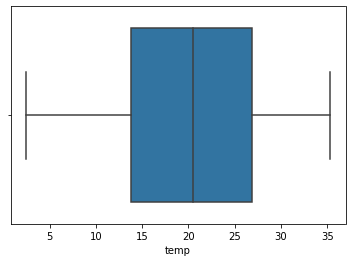

In [19]:
# outliers
df, outliers = eleminate_upper_ouliers(df, "temp")

**Conclusion**: no outliers found in "temp"

##### atemp

In [20]:
df["atemp"].describe()

count    730.000000
mean      23.726322
std        8.150308
min        3.953480
25%       16.889713
50%       24.368225
75%       30.445775
max       42.044800
Name: atemp, dtype: float64

<AxesSubplot:xlabel='atemp'>

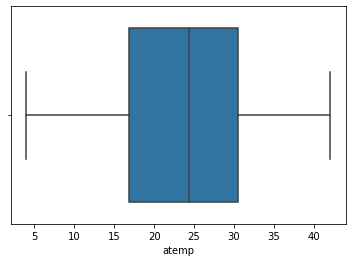

In [21]:
sns.boxplot(df["atemp"])

Upper outliers of dataset: 50.77986874999999
Num rows of outliers: 0
A look of boxplot after remove outliers


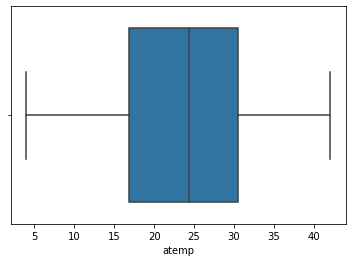

In [22]:
# outliers
df, outliers = eleminate_upper_ouliers(df, "atemp")

**Conclusion**: no outliers found in "temp"

##### hum

In [23]:
df["hum"].describe()

count    730.000000
mean      62.765175
std       14.237589
min        0.000000
25%       52.000000
50%       62.625000
75%       72.989575
max       97.250000
Name: hum, dtype: float64

<AxesSubplot:xlabel='hum'>

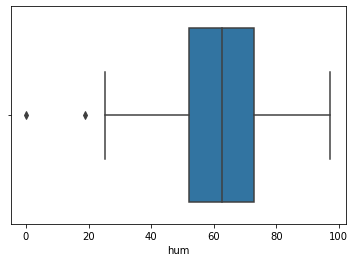

In [24]:
sns.boxplot(df["hum"])

Upper outliers of dataset: 104.4739375
Num rows of outliers: 0
A look of boxplot after remove outliers


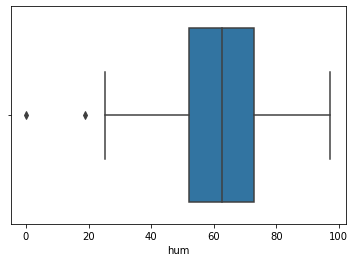

In [25]:
# outliers
df, outliers = eleminate_upper_ouliers(df, "hum")

**Conclusion**: no outliers found in "hum"

##### windspeed

In [26]:
df["windspeed"].describe()

count    730.000000
mean      12.763620
std        5.195841
min        1.500244
25%        9.041650
50%       12.125325
75%       15.625589
max       34.000021
Name: windspeed, dtype: float64

<AxesSubplot:xlabel='windspeed'>

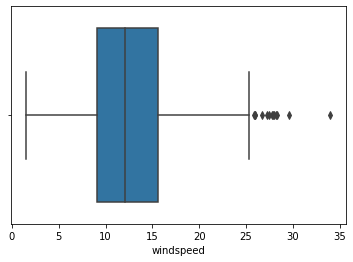

In [27]:
sns.boxplot(df["windspeed"])

Upper outliers of dataset: 25.501498124999998
Num rows of outliers: 13
A look of boxplot after remove outliers


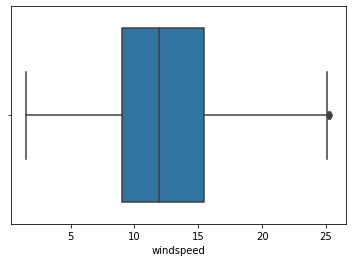

In [28]:
# outliers
df, outliers = eleminate_upper_ouliers(df, "windspeed")

**Conclusion**: With the assumption that windspeed is normal distibution, delete 13 samples

##### cnt

In [29]:
df["cnt"].describe()

count     717.000000
mean     4531.154812
std      1936.429965
min        22.000000
25%      3214.000000
50%      4570.000000
75%      6031.000000
max      8714.000000
Name: cnt, dtype: float64

<AxesSubplot:xlabel='cnt'>

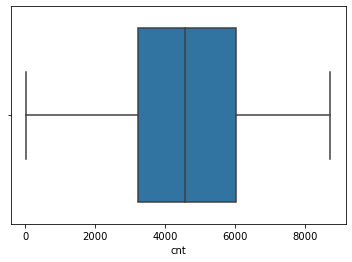

In [30]:
sns.boxplot(df["cnt"])

Upper outliers of dataset: 10256.5
Num rows of outliers: 0
A look of boxplot after remove outliers


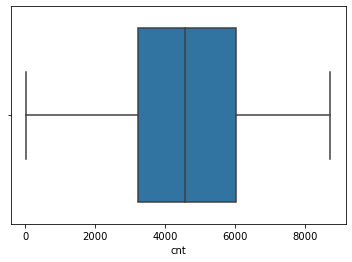

In [31]:
# outliers
df, outliers = eleminate_upper_ouliers(df, "cnt")

**Conclusion**: No outliers found in cnt (target variable)

### 2.4. Derive data
Derive "dteday" to "day" and remove "dteday"
day: categorical: 1-10: 0 (start-month), 11-20: 1 (mid-month), 21-30: 2 (end-month)
<br>
Derive "temp" to categorical: very_cold(<10), cold(10-15), normal(15-20), warm (20-25), hot(25-30), veryhot(>30)
<br>
Link: https://science.howstuffworks.com/nature/climate-weather/atmospheric/question651.htm#:~:text=Most%20people%20are%20comfortable%20with,and%20unable%20to%20cool%20down.
Derive "hum" by the link: dry (<30), good(30-50), wet(>50)
<br>
Windspeed range: https://www.weather.gov/pqr/wind
Derive "windspeed": calm(<1), light_air(1-3), light_breeze(4-7), gentle_breeze(8-12), moderate_breeze(13-18), fresh_freeze(19-24), strong_breeze(25-31) and near_gate(>=32)	

In [32]:
part_month = lambda x: 0 if x<11 else 1 if x<21 else 2
df["day"] = [part_month(int(i.day)) for i in df['dteday']]
df.drop(['dteday'], axis=1, inplace=True)
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,day
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,985,0
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,801,0
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,1349,0
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,1562,0
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,1600,0


In [33]:
temp_names = ["very_cold", "cold", "normal", "warm", "hot", "veryhot"]
df["temp_cat"] = df["temp"].apply(lambda x: temp_names[int(x-10)//5] if x>10 else temp_names[0])
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,day,temp_cat
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,985,0,very_cold
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,801,0,very_cold
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,1349,0,very_cold
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,1562,0,very_cold
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,1600,0,very_cold


In [34]:
hum_names = ["dry", "good", "wet"]
df["hum_cat"] = df["hum"].apply(lambda x: hum_names[0] if x<30 else hum_names[2] if x>50 else hum_names[1])
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,day,temp_cat,hum_cat
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,985,0,very_cold,wet
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,801,0,very_cold,wet
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,1349,0,very_cold,good
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,1562,0,very_cold,wet
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,1600,0,very_cold,good


In [35]:
wind_names = ["calm", "light_air", "light_breeze", "gentle_breeze", "moderate_breeze", "fresh_freeze", "strong_breeze", "near_gate"]
def devide_speed(x):
    if x<1:
        wind_name = "calm"
    elif x<4:
        wind_name = "light_air"
    elif x<8:
        wind_name = "light_breeze"
    elif x<13:
        wind_name = "gentle_breeze"
    elif x<19:
        wind_name = "moderate_breeze"
    elif x<25:
        wind_name = "fresh_freeze"
    elif x<32:
        wind_name = "strong_breeze"
    else:
        wind_name = "near_gate"
    return wind_name
df["windspeed_cat"] = df["windspeed"].apply(lambda x:devide_speed(x))
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,day,temp_cat,hum_cat,windspeed_cat
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,985,0,very_cold,wet,gentle_breeze
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,801,0,very_cold,wet,moderate_breeze
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,1349,0,very_cold,good,moderate_breeze
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,1562,0,very_cold,wet,gentle_breeze
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,1600,0,very_cold,good,gentle_breeze


### 2.5. Correlation between attributes

In [36]:
corr_matrix = df.corr()

<AxesSubplot:>

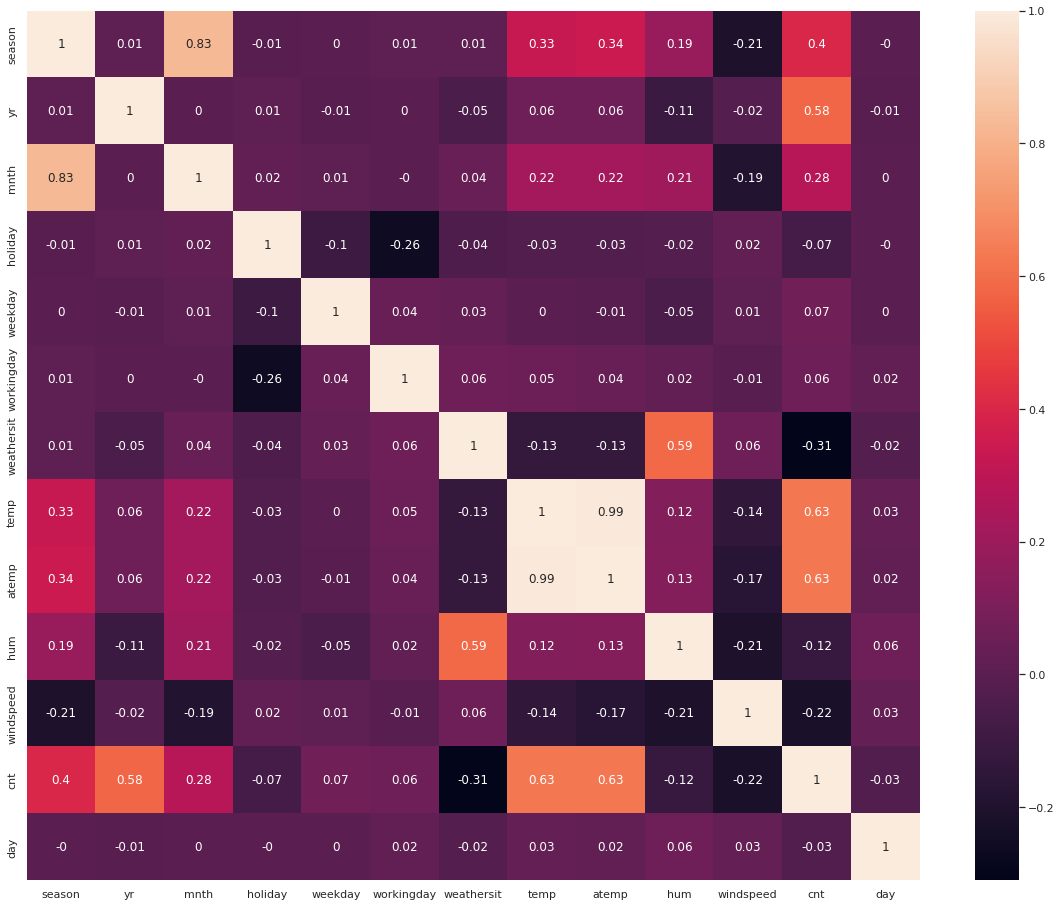

In [37]:
sns.set(rc={'figure.figsize':(20,16)})
sns.heatmap(round(df.corr(), 2), annot=True)

In [38]:
# finding high coorelation attributes
upper_matrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(bool))
to_drop = [column for column in upper_matrix.columns if any(np.abs(upper_matrix[column]) > 0.95)]
print("Drop columns:", to_drop)
df = df.drop(to_drop, axis=1)

Drop columns: ['atemp']


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 717 entries, 0 to 729
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   season         717 non-null    int64  
 1   yr             717 non-null    int64  
 2   mnth           717 non-null    int64  
 3   holiday        717 non-null    int64  
 4   weekday        717 non-null    int64  
 5   workingday     717 non-null    int64  
 6   weathersit     717 non-null    int64  
 7   temp           717 non-null    float64
 8   hum            717 non-null    float64
 9   windspeed      717 non-null    float64
 10  cnt            717 non-null    int64  
 11  day            717 non-null    int64  
 12  temp_cat       717 non-null    object 
 13  hum_cat        717 non-null    object 
 14  windspeed_cat  717 non-null    object 
dtypes: float64(3), int64(9), object(3)
memory usage: 89.6+ KB


**Conclusion**: As we see, temp and atemp are high correlations, so we drop attemp to reduce dimensions of data

### 2.6. EDA

#### 2.6.1 Univariate analysis

<AxesSubplot:xlabel='temp', ylabel='Density'>

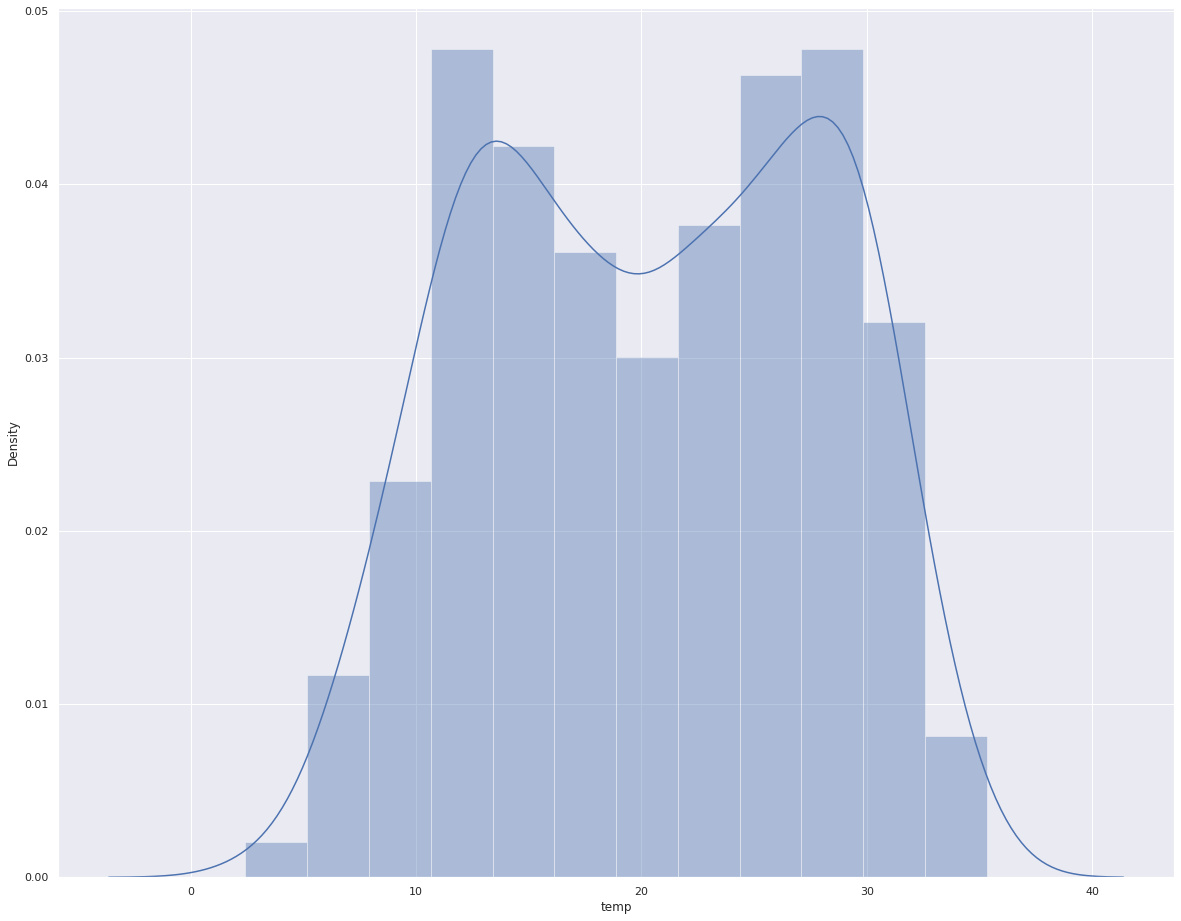

In [40]:
# temperature
sns.distplot(df["temp"])

<AxesSubplot:xlabel='hum', ylabel='Density'>

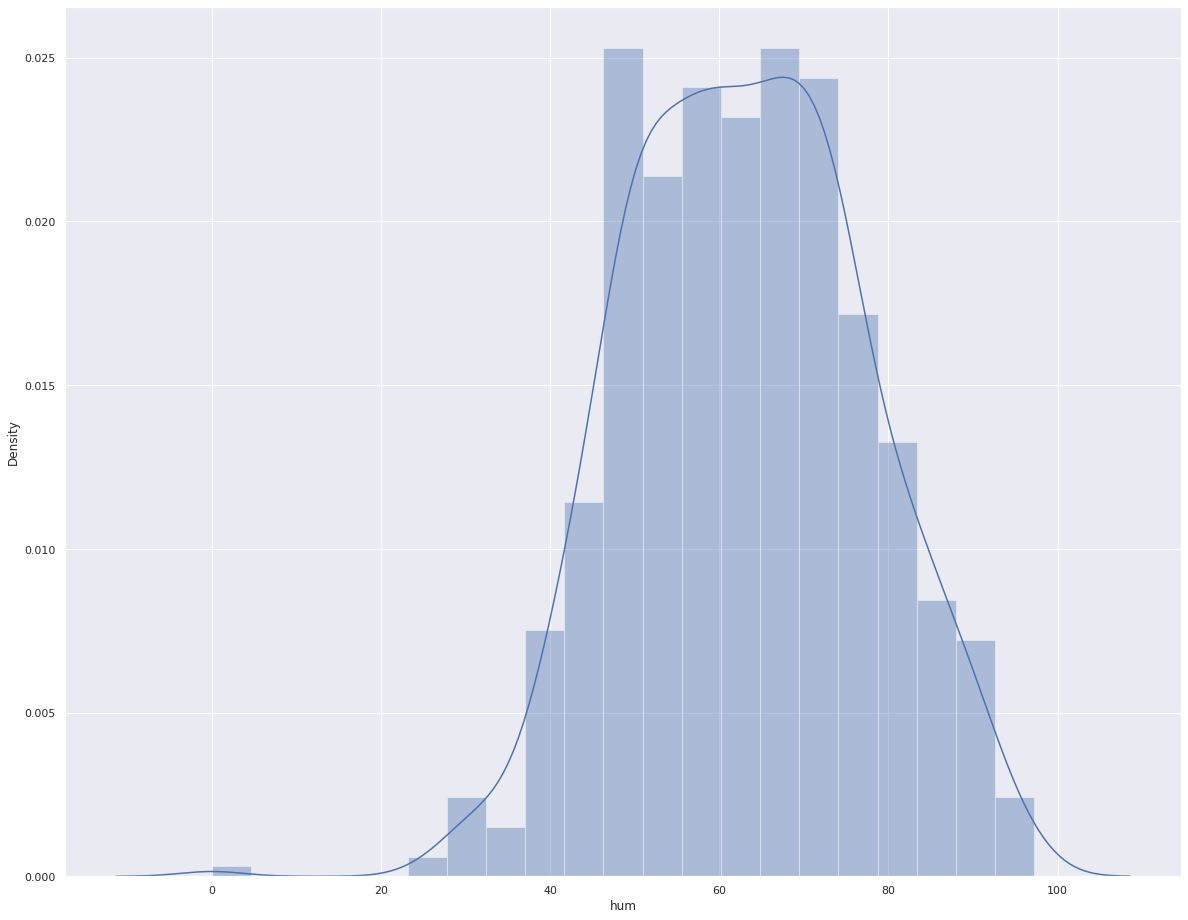

In [41]:
# humidity
sns.distplot(df["hum"])

<AxesSubplot:xlabel='windspeed', ylabel='Density'>

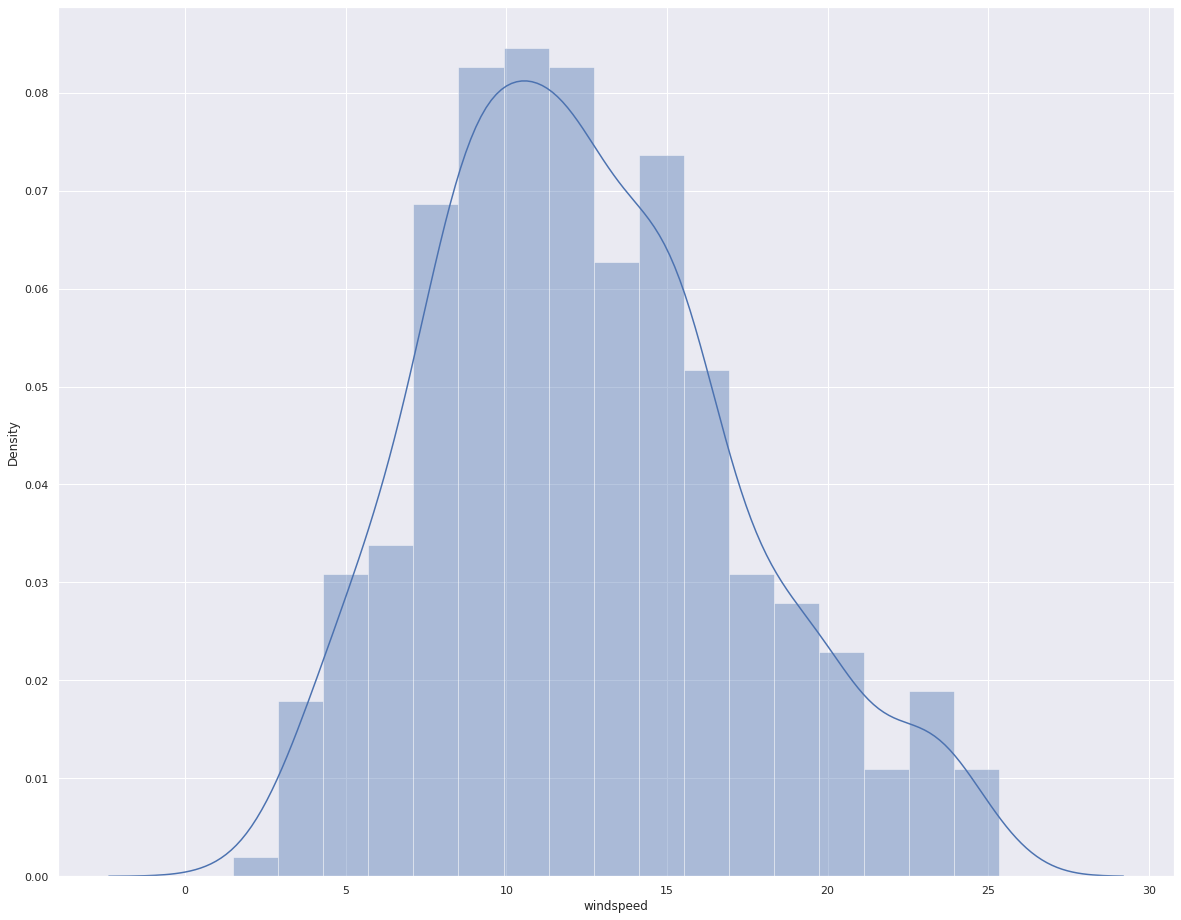

In [42]:
# windspeed
sns.distplot(df["windspeed"])

<AxesSubplot:xlabel='cnt', ylabel='Density'>

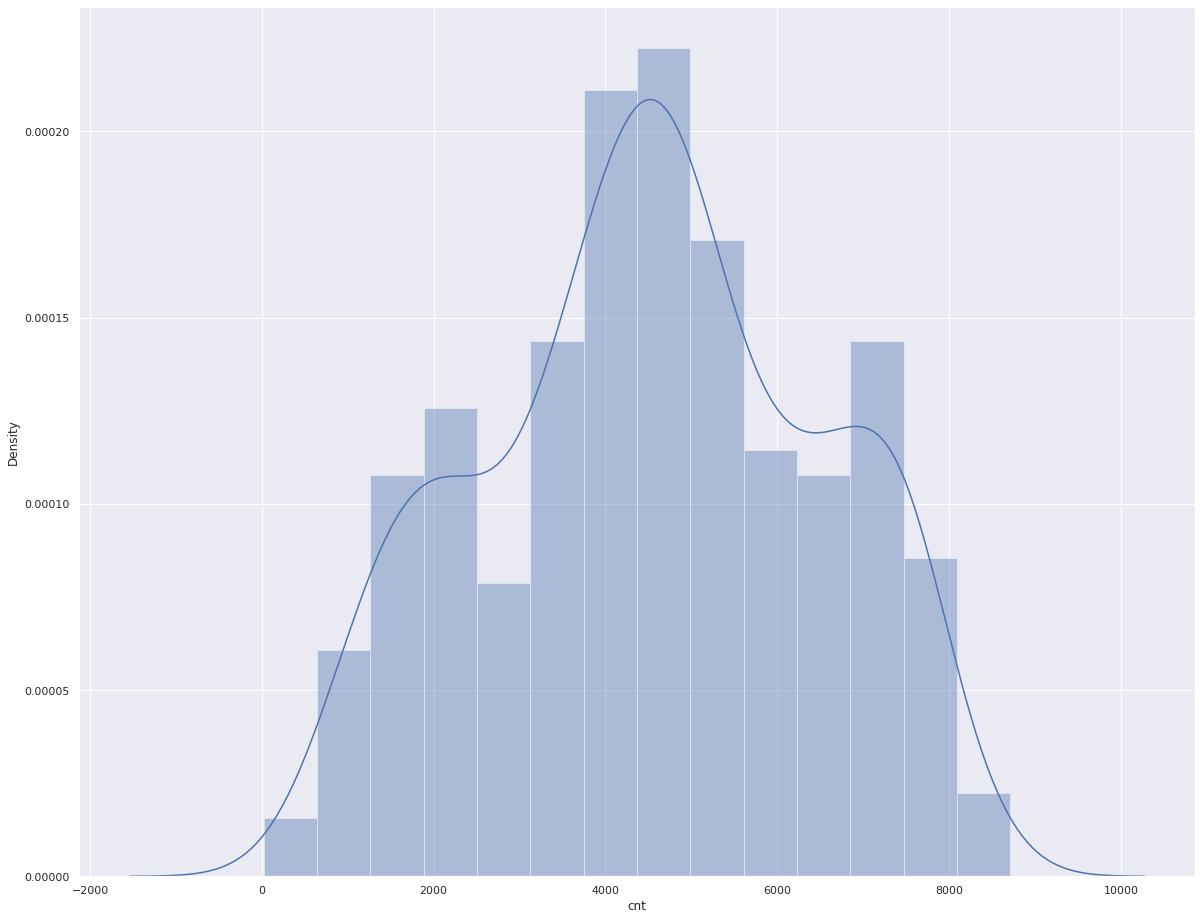

In [43]:
# count
sns.distplot(df["cnt"])

#### 2.6.2 Bivariate analysis

##### 2.6.2.1. Betweenn continous variable

<Figure size 1080x2160 with 0 Axes>

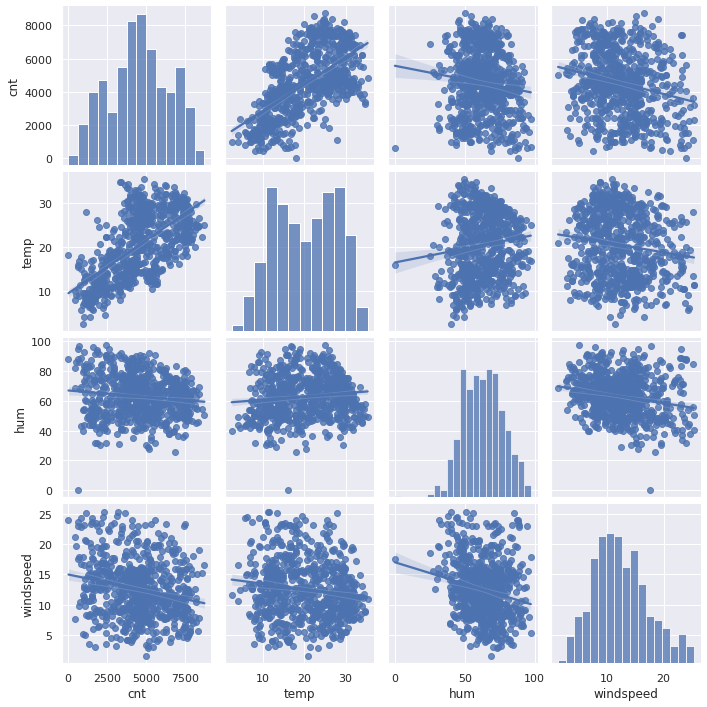

In [44]:
plt.figure(figsize = (15,30))
sns.pairplot(data=df,vars=['cnt', 'temp', 'hum','windspeed'], kind='reg')
plt.show()

<AxesSubplot:>

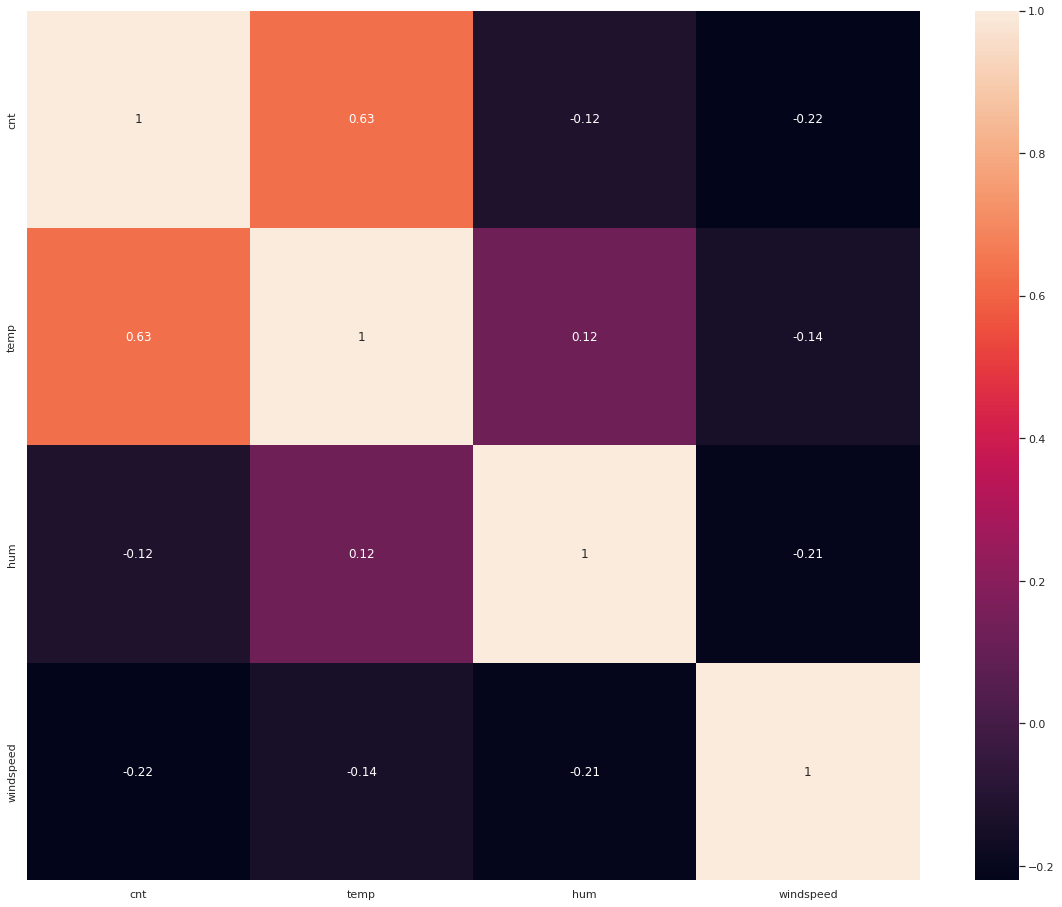

In [45]:
corr_matrix = df[['cnt', 'temp', 'hum','windspeed']].corr()
sns.set(rc={'figure.figsize':(20,16)})
sns.heatmap(round(corr_matrix, 2), annot=True)

**Finding**: from pairplot and coorelation heatmap we can see temp is higher correlation to windspeed and hum, respectively.

##### 2.6.2.2. Betweenn categorical variable

In [46]:
# Converting season , day, and months's numerical values to categorical values
df.season.replace({1:"spring", 2:"summer", 3:"fall", 4:"winter"},inplace = True)

df.mnth = df.mnth.replace({1: 'jan',2: 'feb',3: 'mar',4: 'apr',5: 'may',6: 'jun',
                  7: 'jul',8: 'aug',9: 'sept',10: 'oct',11: 'nov',12: 'dec'})

df.weathersit.replace({1:'clear',2:'Mist',3:'Snow',4:'Heavy_Rain'},inplace = True)

df.weekday = df.weekday.replace({0: 'sun',1: 'mon',2: 'tue',3: 'wed',4: 'thu',5: 'fri',6: 'sat'})

df.day = df.day.replace({0:'start_month', 1:'mid_month', 2:'end_month'})


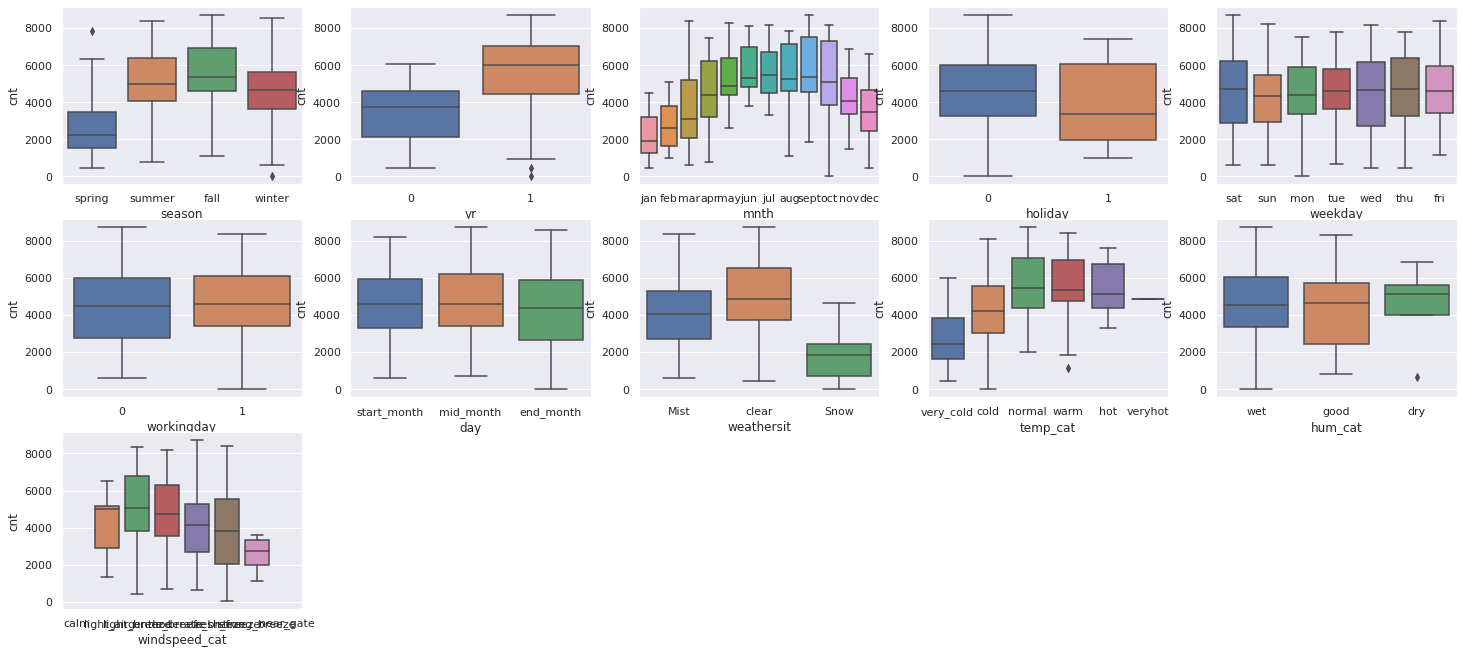

In [47]:
lst = ['season','yr','mnth','holiday','weekday','workingday', 'day','weathersit', 'temp_cat', 'hum_cat','windspeed_cat']

plt.figure(figsize=(25, 15))
for i, col_name in enumerate(lst):
    plt.subplot(4,5,i+1)
    if col_name == "windspeed_cat":
        sns.boxplot(data=df, x=col_name, y='cnt', order=wind_names)
    else:
        sns.boxplot(data=df, x=col_name, y='cnt')
plt.show()

**Finding**:
Bike sharing bussiness:
<ul>
    <li>Demand by season, from high to low: 3 (Fall), 2 (Summer), 4 (Winter) and 1 (Fall), respectively.</li>
    <li>Demand increase in 2019 compared to 2018</li>
    <li>Demand in a year increase from January to September, then fall back.</li>
    <li>Demand is higher when it is joliday</li>
    <li>Weekends have slighty higher demand, but the mean is more or less the same. We can derive that there is not much impact of day of week in the data. And similar is with working day</li>
    <li>End days of month have slightly decrease in number</bi>
    <li>Weather impact much in demand: the worse weather is, the lower in demand.</li>
    <li>People would like to have more demand on warm temperate day</li>
    <li>Humidity not affected much for demand</li>
    <li>The demand go highest in light air or light breeze day</li>
</ul>

# Data prepatation
Data provide with independent variables

## 1 Create dummy variables

In [48]:
df = pd.get_dummies(data=df,columns=["season", "mnth", "day","weekday",
                                     "weathersit", 'temp_cat', 'hum_cat','windspeed_cat'],drop_first=True)

In [49]:
df.describe()

,yr,holiday,workingday,temp,hum,windspeed,cnt,season_spring,season_summer,season_winter,...,temp_cat_very_cold,temp_cat_veryhot,temp_cat_warm,hum_cat_good,hum_cat_wet,windspeed_cat_gentle_breeze,windspeed_cat_light_air,windspeed_cat_light_breeze,windspeed_cat_moderate_breeze,windspeed_cat_strong_breeze
count,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,...,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000
mean,0.497908,0.029289,0.684798,20.394513,63.043984,12.488931,4531.154812,0.239888,0.252441,0.245467,...,0.301255,0.001395,0.237099,0.186890,0.807531,0.412831,0.016736,0.157601,0.301255,0.005579
std,0.500345,0.168732,0.464921,7.526460,14.105580,4.813331,1936.429965,0.427313,0.434716,0.430664,...,0.459124,0.037346,0.425600,0.390095,0.394514,0.492687,0.128372,0.364621,0.459124,0.074535
min,0.000000,0.000000,0.000000,2.424346,0.000000,1.500244,22.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,13.837500,52.458300,9.000043,3214.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,20.739153,63.083300,11.959232,4570.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,26.923347,73.250000,15.458575,6031.000000,0.000000,1.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,35.328347,97.250000,25.333236,8714.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 717 entries, 0 to 729
Data columns (total 43 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   yr                             717 non-null    int64  
 1   holiday                        717 non-null    int64  
 2   workingday                     717 non-null    int64  
 3   temp                           717 non-null    float64
 4   hum                            717 non-null    float64
 5   windspeed                      717 non-null    float64
 6   cnt                            717 non-null    int64  
 7   season_spring                  717 non-null    uint8  
 8   season_summer                  717 non-null    uint8  
 9   season_winter                  717 non-null    uint8  
 10  mnth_aug                       717 non-null    uint8  
 11  mnth_dec                       717 non-null    uint8  
 12  mnth_feb                       717 non-null    uin

## 2 Devide data to train and test

In [51]:
#y to contain only target variable
y = df['cnt']

#X is all remainign variable also our independent variables
X = df.drop('cnt', axis=1)

#Train Test split with 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [52]:
print("X_train: ",X_train.shape)
print("y_train: ",y_train.shape)
print("X_test:  ",X_test.shape)
print("y_test:  ",y_test.shape)

X_train:  (573, 42)
y_train:  (573,)
X_test:   (144, 42)
y_test:   (144,)


## 3 Perform scaling
"StandardScaler therefore cannot guarantee balanced feature scales in the presence of outliers." - sckitlearn website. So we choose MinMaxScaler

In [53]:
#Scale all the variable fron 0 to 1
scaler = MinMaxScaler()
num_vars = ['temp','hum','windspeed']
X_train[num_vars] = scaler.fit_transform(X_train[num_vars])
# note that X_test use the transform fit before with X_train
X_test[num_vars] = scaler.transform(X_test[num_vars])

In [54]:
X_train.head()

,yr,holiday,workingday,temp,hum,windspeed,season_spring,season_summer,season_winter,mnth_aug,...,temp_cat_very_cold,temp_cat_veryhot,temp_cat_warm,hum_cat_good,hum_cat_wet,windspeed_cat_gentle_breeze,windspeed_cat_light_air,windspeed_cat_light_breeze,windspeed_cat_moderate_breeze,windspeed_cat_strong_breeze
666,1,0,1,0.474582,0.871230,0.944034,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
555,1,0,1,0.824514,0.575406,0.363619,0,0,0,0,...,0,0,1,0,1,1,0,0,0,0
724,1,0,1,0.229525,0.792343,0.826935,1,0,0,0,...,1,0,0,0,1,0,0,0,0,0
678,1,0,0,0.411242,0.544664,0.099670,0,0,1,0,...,0,0,0,0,1,0,1,0,0,0
527,1,0,1,0.740406,0.806264,0.540190,0,1,0,0,...,0,0,1,0,1,0,0,0,1,0


In [55]:
X_train.describe()

,yr,holiday,workingday,temp,hum,windspeed,season_spring,season_summer,season_winter,mnth_aug,...,temp_cat_very_cold,temp_cat_veryhot,temp_cat_warm,hum_cat_good,hum_cat_wet,windspeed_cat_gentle_breeze,windspeed_cat_light_air,windspeed_cat_light_breeze,windspeed_cat_moderate_breeze,windspeed_cat_strong_breeze
count,573.000000,573.000000,573.000000,573.000000,573.000000,573.000000,573.000000,573.000000,573.000000,573.000000,...,573.000000,573.000000,573.000000,573.000000,573.000000,573.000000,573.000000,573.000000,573.000000,573.000000
mean,0.502618,0.027923,0.694590,0.551739,0.528278,0.452801,0.221640,0.251309,0.254799,0.095986,...,0.301920,0.001745,0.244328,0.178010,0.816754,0.424084,0.017452,0.169284,0.286213,0.005236
std,0.500430,0.164897,0.460983,0.229767,0.189304,0.201242,0.415713,0.434145,0.436129,0.294829,...,0.459492,0.041776,0.430064,0.382856,0.387206,0.494635,0.131063,0.375331,0.452385,0.072231
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.352054,0.390370,0.305955,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.561806,0.531322,0.426594,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.755981,0.662993,0.580424,0.000000,1.000000,1.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# DATA MODELLING AND EVALUATION

### 1.1. Model with all attributes

R2 Score of the training data: 0.8795133283464509
R2 Score of the testing data: 0.8686502244169512
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     94.54
Date:                Sat, 16 Apr 2022   Prob (F-statistic):          5.78e-216
Time:                        07:48:09   Log-Likelihood:                -4532.3
No. Observations:                 573   AIC:                             9149.
Df Residuals:                     531   BIC:                             9331.
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------

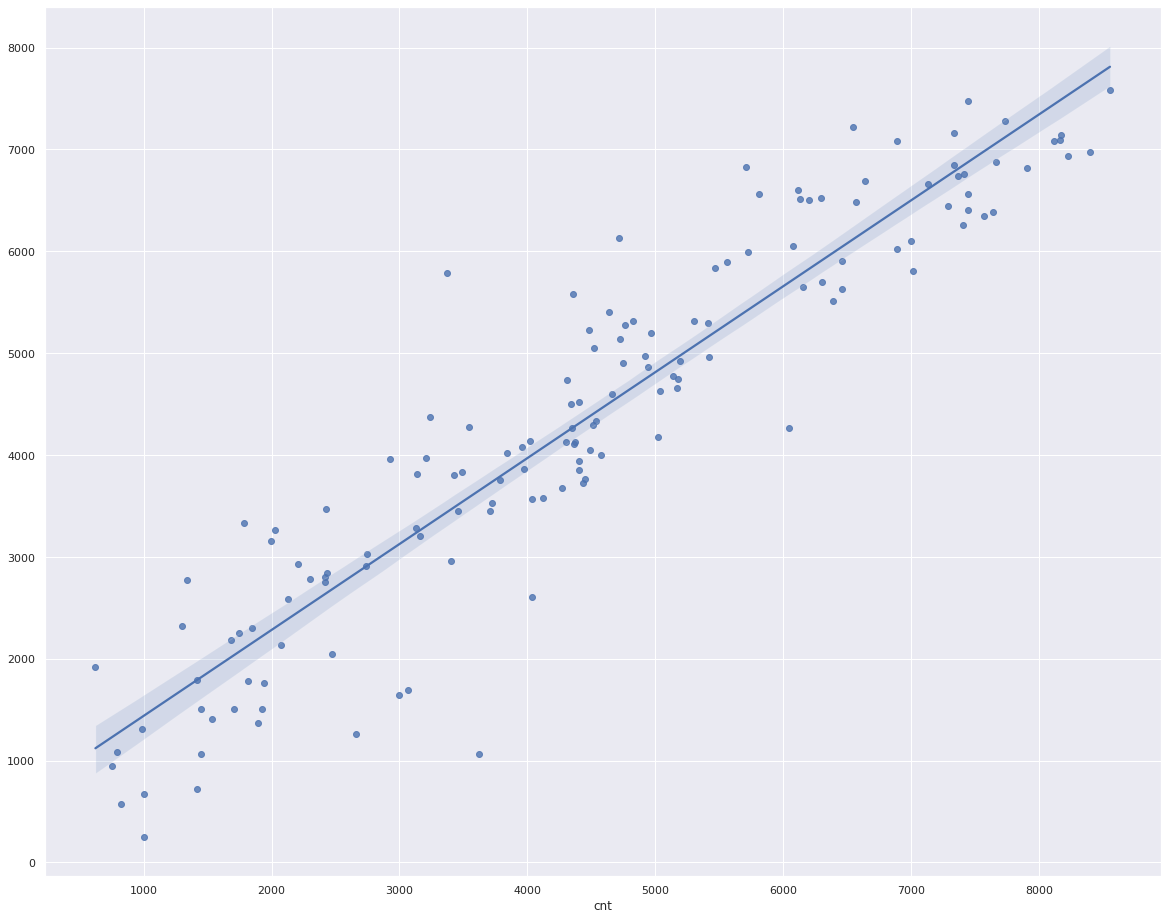

In [56]:
model_1 = linear_regression(X_train, y_train, X_test, y_test)

After getting the intial results we see that although our R2 and adj.R2 is 88% and 87%, our F statistic is low and also we see that the p value for lot of our variables is very high. we also see a problem of multi-collinearity.

### 1.2. Model using RFE variables

In [57]:
# # Linear Regression model with all attributes
model_1 = LinearRegression()
model_1.fit(X_train, y_train)

LinearRegression()

In [58]:
# Using RFE to rank 20 columns
# Despite the recommendation were 15, but when choosing top 15 in this project may cause lost of a lot infomation
rfe = RFE(model_1, n_features_to_select=20, step=1, verbose=0, importance_getter='auto')
rfe.fit(X_train,y_train)
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('season_spring', True, 1),
 ('season_summer', False, 11),
 ('season_winter', True, 1),
 ('mnth_aug', False, 19),
 ('mnth_dec', False, 17),
 ('mnth_feb', False, 5),
 ('mnth_jan', False, 7),
 ('mnth_jul', False, 18),
 ('mnth_jun', False, 20),
 ('mnth_mar', True, 1),
 ('mnth_may', False, 10),
 ('mnth_nov', False, 12),
 ('mnth_oct', False, 2),
 ('mnth_sept', True, 1),
 ('day_mid_month', False, 9),
 ('day_start_month', False, 8),
 ('weekday_mon', False, 6),
 ('weekday_sat', True, 1),
 ('weekday_sun', False, 13),
 ('weekday_thu', False, 16),
 ('weekday_tue', False, 15),
 ('weekday_wed', False, 21),
 ('weathersit_Snow', True, 1),
 ('weathersit_clear', True, 1),
 ('temp_cat_hot', True, 1),
 ('temp_cat_normal', True, 1),
 ('temp_cat_very_cold', True, 1),
 ('temp_cat_veryhot', True, 1),
 ('temp_cat_warm', False, 3),
 ('hum_cat_good', True, 1),
 ('hum_cat_wet', True

R2 Score of the training data: 0.8727048661978185
R2 Score of the testing data: 0.8753333200870341
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     189.2
Date:                Sat, 16 Apr 2022   Prob (F-statistic):          7.52e-232
Time:                        07:48:10   Log-Likelihood:                -4548.0
No. Observations:                 573   AIC:                             9138.
Df Residuals:                     552   BIC:                             9229.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------

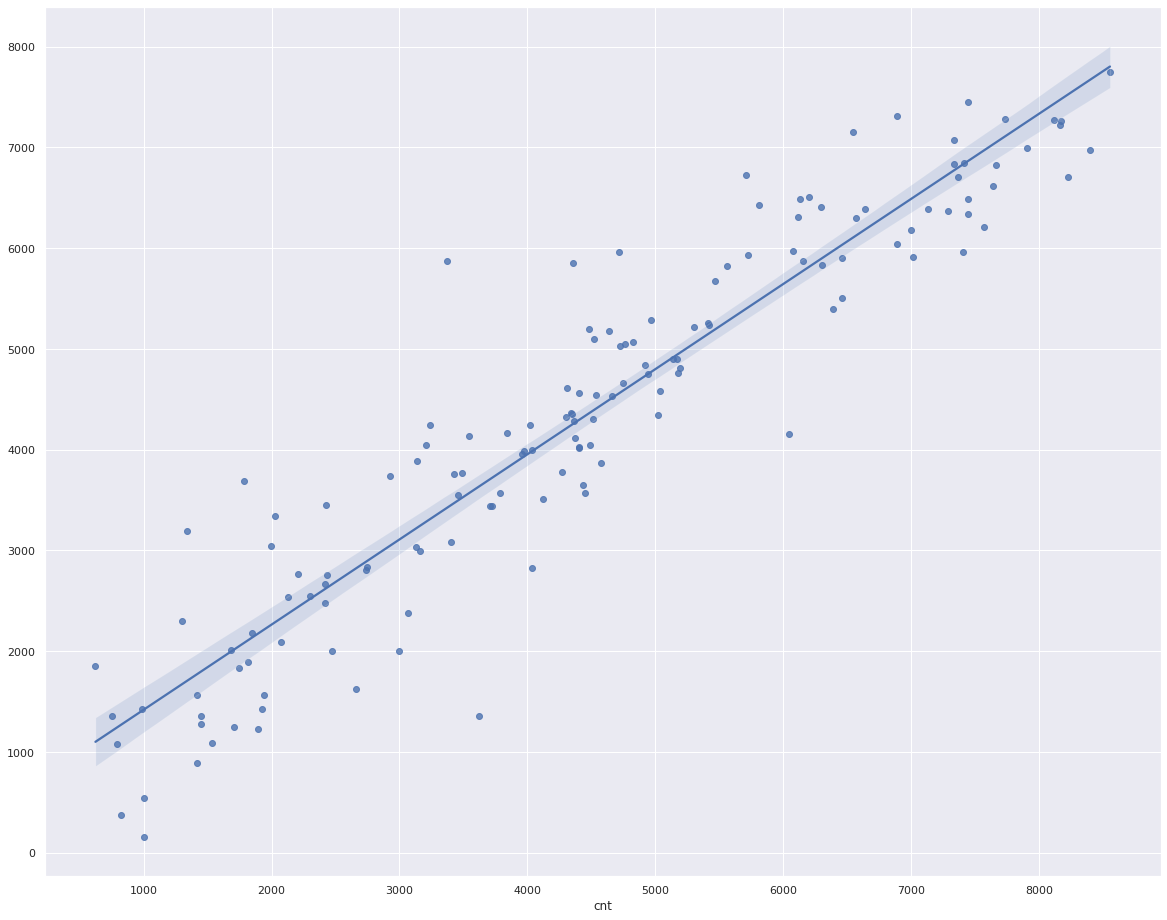

In [59]:
X_train_RFE = X_train[X_train.columns[rfe.support_]]
X_test_RFE  = X_test[X_test.columns[rfe.support_]]
model_2     = linear_regression(X_train_RFE, y_train, X_test_RFE, y_test)

After creating our 2nd model using RFE feature selection technique we see that our adj.R2 have decreased a little compared to our 1st model and our F-statictic has also significantly increased suggesting a better fit. Also, RFE took care of the multi collinearity problem for us and we do not see high much P-values for the variables

### 1.3 Feature Selection Using VIF and P-Values

In [60]:
cols = list(X_train.columns[rfe.support_])
X_train_RFE = X_train[cols]
X_test_RFE  = X_test[cols]
model_3 = linear_regression(X_train[cols], y_train, X_test[cols], y_test, print_chart=False)
print(get_VIF(X_train[cols]))

R2 Score of the training data: 0.8727048661978185
R2 Score of the testing data: 0.8753333200870341
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     189.2
Date:                Sat, 16 Apr 2022   Prob (F-statistic):          7.52e-232
Time:                        07:48:10   Log-Likelihood:                -4548.0
No. Observations:                 573   AIC:                             9138.
Df Residuals:                     552   BIC:                             9229.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------

In [61]:
cols.remove('hum_cat_good')
model_3 = linear_regression(X_train[cols], y_train, X_test[cols], y_test, print_chart=False)
print(get_VIF(X_train[cols]))

R2 Score of the training data: 0.87239639308142
R2 Score of the testing data: 0.8732120381309821
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     199.0
Date:                Sat, 16 Apr 2022   Prob (F-statistic):          1.02e-232
Time:                        07:48:10   Log-Likelihood:                -4548.7
No. Observations:                 573   AIC:                             9137.
Df Residuals:                     553   BIC:                             9224.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------

In [62]:
cols.remove('workingday')
model_3 = linear_regression(X_train[cols], y_train, X_test[cols], y_test, print_chart=False)
print(get_VIF(X_train[cols]))

R2 Score of the training data: 0.8696517595600146
R2 Score of the testing data: 0.8693076979319293
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     205.3
Date:                Sat, 16 Apr 2022   Prob (F-statistic):          2.46e-231
Time:                        07:48:10   Log-Likelihood:                -4554.8
No. Observations:                 573   AIC:                             9148.
Df Residuals:                     554   BIC:                             9230.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------

In [63]:
cols.remove('hum')
model_3 = linear_regression(X_train[cols], y_train, X_test[cols], y_test, print_chart=False)
print(get_VIF(X_train[cols]))

R2 Score of the training data: 0.8572214791645008
R2 Score of the testing data: 0.8562103497216056
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     196.0
Date:                Sat, 16 Apr 2022   Prob (F-statistic):          1.40e-221
Time:                        07:48:10   Log-Likelihood:                -4580.9
No. Observations:                 573   AIC:                             9198.
Df Residuals:                     555   BIC:                             9276.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------

In [64]:
cols.remove('hum_cat_wet')
model_3 = linear_regression(X_train[cols], y_train, X_test[cols], y_test, print_chart=False)
print(get_VIF(X_train[cols]))

R2 Score of the training data: 0.8571463757178106
R2 Score of the testing data: 0.8551510497895101
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     208.5
Date:                Sat, 16 Apr 2022   Prob (F-statistic):          1.10e-222
Time:                        07:48:10   Log-Likelihood:                -4581.1
No. Observations:                 573   AIC:                             9196.
Df Residuals:                     556   BIC:                             9270.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------

### 1.4. Final model

In [65]:
model_final = LinearRegression()
model_final.fit(X_train[cols], y_train)
print("Intercept:", model_final.intercept_)
print("Coef     :\n", model_final.coef_)

Intercept: 1484.6491415659893
Coef     :
 [ 2037.54696607  -841.03748787  3846.07337739  -766.67098899
  -923.48342301   408.51396001   307.70077276   269.64824028
   315.81333325 -1732.54434116   734.20406371  -883.39495721
   414.30718619  -246.44787831 -3274.04150401 -1926.57743793]


## 2. MODEL EVALUATION

**Reference**: 
<ul>
    <li>https://towardsdatascience.com/assumptions-of-linear-regression-fdb71ebeaa8b</li>
    <li>https://towardsdatascience.com/how-do-you-check-the-quality-of-your-regression-model-in-python-fa61759ff685</li>
</ul>
<br>


**Note**: 4 keys assumtions
<ul>
    <li>Linearity</li>
    <li>Muilticolinearity</li>
    <li>Homoscedasticity</li>
    <li>Normality</li>
</ul>

### 2.1. Linearity

The expected value of the dependent variable is a linear function of each independent variable, holding the others fixed

In [66]:
cols_linearity = copy.deepcopy(cols)
cols_linearity.append('cnt')
print(cols_linearity)

['yr', 'holiday', 'temp', 'windspeed', 'season_spring', 'season_winter', 'mnth_mar', 'mnth_sept', 'weekday_sat', 'weathersit_Snow', 'weathersit_clear', 'temp_cat_hot', 'temp_cat_normal', 'temp_cat_very_cold', 'temp_cat_veryhot', 'windspeed_cat_strong_breeze', 'cnt']


In [67]:
df[cols_linearity].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 717 entries, 0 to 729
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   yr                           717 non-null    int64  
 1   holiday                      717 non-null    int64  
 2   temp                         717 non-null    float64
 3   windspeed                    717 non-null    float64
 4   season_spring                717 non-null    uint8  
 5   season_winter                717 non-null    uint8  
 6   mnth_mar                     717 non-null    uint8  
 7   mnth_sept                    717 non-null    uint8  
 8   weekday_sat                  717 non-null    uint8  
 9   weathersit_Snow              717 non-null    uint8  
 10  weathersit_clear             717 non-null    uint8  
 11  temp_cat_hot                 717 non-null    uint8  
 12  temp_cat_normal              717 non-null    uint8  
 13  temp_cat_very_cold  

In [68]:
cols_linearity = ['temp', 'windspeed', 'cnt']

<Figure size 1080x2160 with 0 Axes>

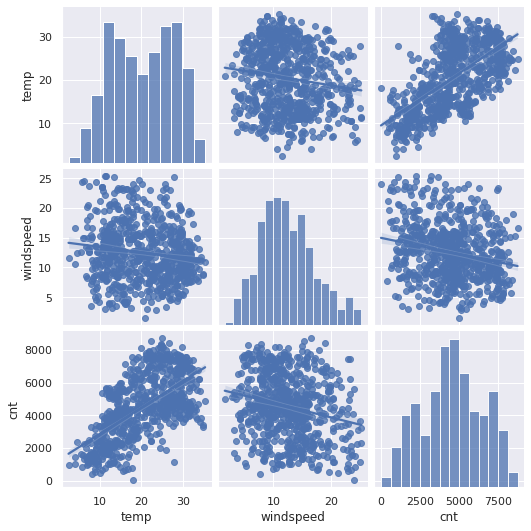

In [69]:
plt.figure(figsize = (15,30))
sns.pairplot(data=df[cols_linearity], kind='reg')
plt.show()

In final model, there only 2 numeric attribute: temp and windspeed.

<br>

By looking at the plots we can see that with the "cnt variable the independent variables form an accurately linear shape but "temp" still better than "windspeed" which seems to hardly have any specific shape. So it shows that a linear regression fitting might not be the best model for it. A linear model might not be able to efficiently explain the data in terms of variability, prediction accuracy etc.


### 2.2 Normality of error terms/residuals

Residuals as we know are the differences between the true value and the predicted value. One of the assumptions of linear regression is that the mean of the residuals should be zero

Text(0.5, 0, 'Errors')

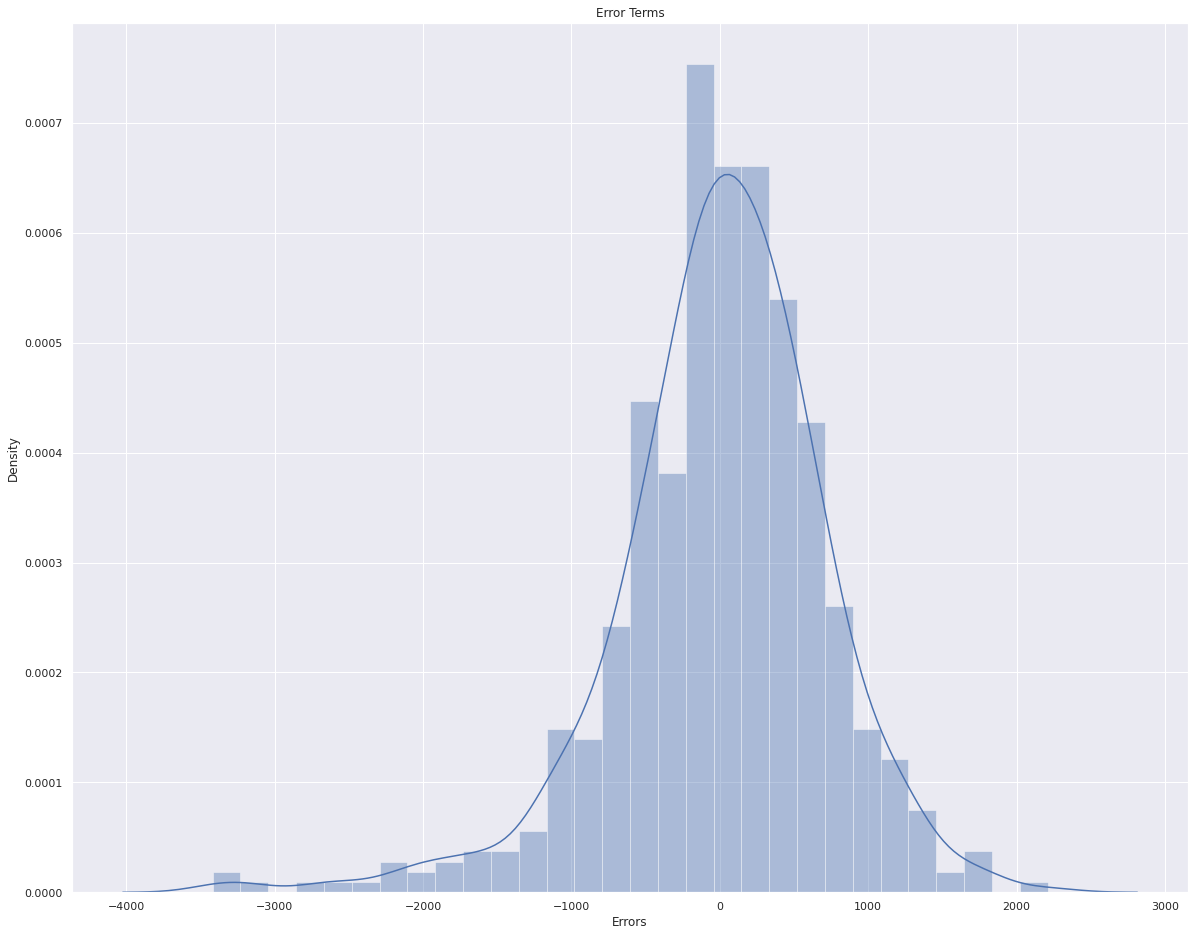

In [70]:
y_train_pred = model_final.predict(X_train[cols])
residuals = y_train-y_train_pred
sns.distplot(residuals)
plt.title('Error Terms')
plt.xlabel('Errors')

Error terms are normally distributed with mean at 0.

### 2.3 Homoscedasticity

Homoscedasticity means that the residuals have equal or almost equal variance across the regression line. By plotting the error terms with predicted terms we can check that there should not be any pattern in the error terms.

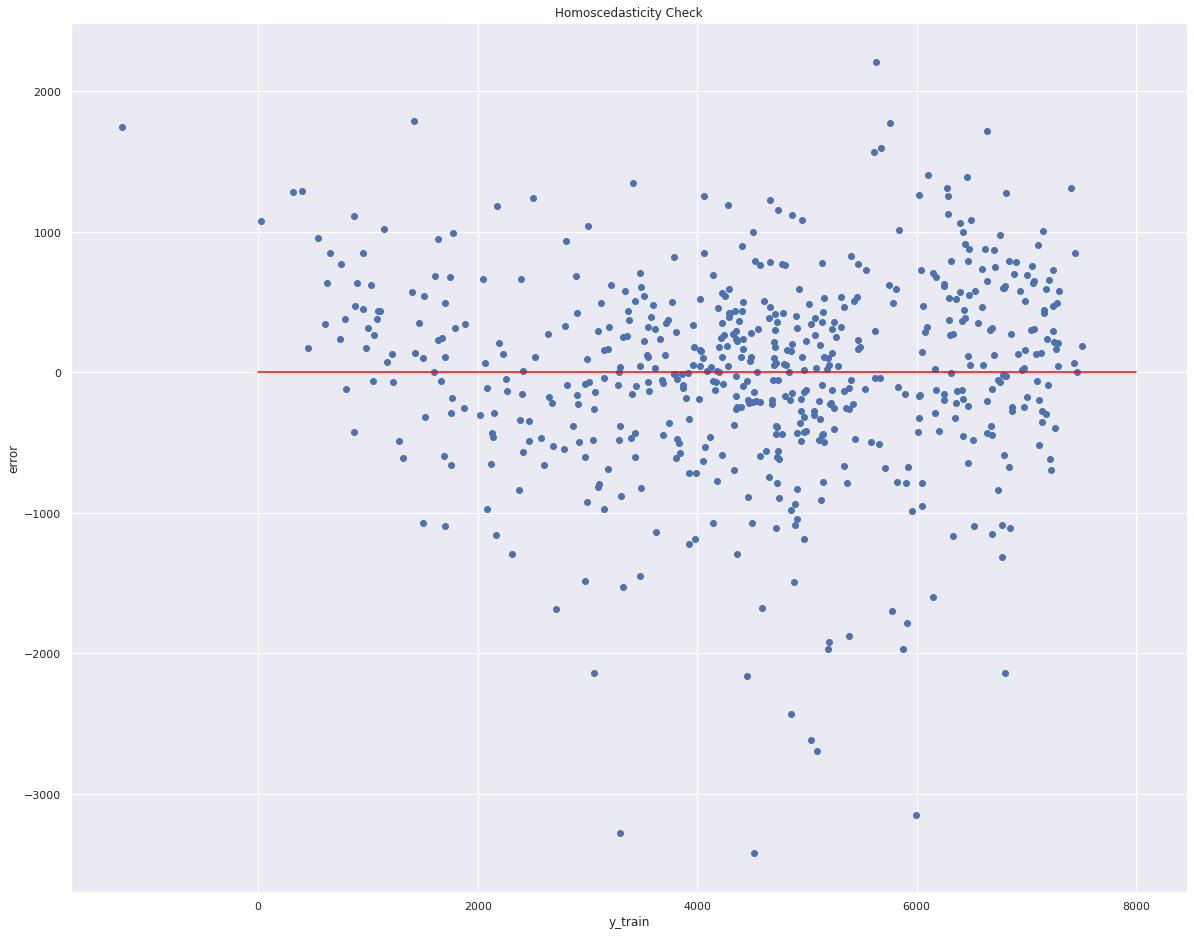

In [71]:
residual = (y_train - y_train_pred)
plt.scatter(y_train_pred,residual)
plt.ylabel("error")
plt.xlabel("y_train")
plt.title('Homoscedasticity Check')
sns.lineplot([0,8000],[0,0],color='red')
plt.show()

This clearly does not look like a constant variance around the zero-line.

### Goldfeld Quandt Test
Checking heteroscedasticity : Using Goldfeld Quandt we test for heteroscedasticity.
<ul>
    <li>Null Hypothesis: Error terms are homoscedastic.</li>
    <li>Alternative Hypothesis: Error terms are heteroscedastic.</li>
</ul>

In [72]:
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(residuals, X_train[cols])
lzip(name, test)

[('F statistic', 1.177149210525878), ('p-value', 0.09000220618862494)]

Since p value is more than 0.05 in Goldfeld Quandt Test, we can't reject it's null hypothesis that error terms are homoscedastic

### 2.4 Multi|collinearity

<AxesSubplot:>

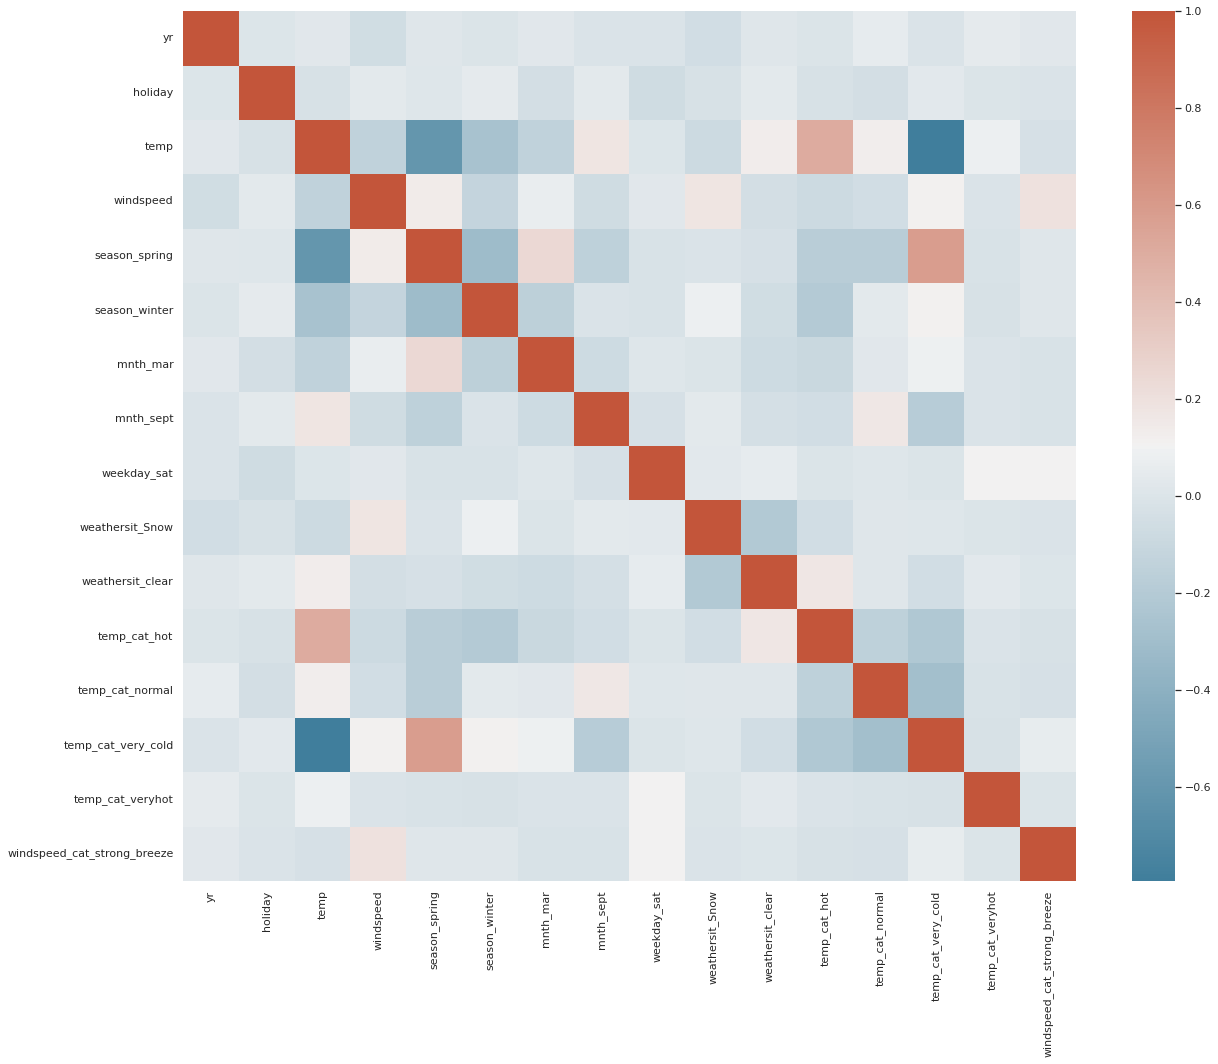

In [73]:
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(X_train[cols].corr(), cmap=cmap)

In [74]:
print(get_VIF(X_train[cols]))

                        feature       VIF
2                          temp  7.487174
3                     windspeed  5.901987
10             weathersit_clear  2.992735
13           temp_cat_very_cold  2.990606
4                 season_spring  2.649241
0                            yr  2.027710
5                 season_winter  1.711514
11                 temp_cat_hot  1.603297
12              temp_cat_normal  1.396955
8                   weekday_sat  1.198839
6                      mnth_mar  1.177868
7                     mnth_sept  1.177022
9               weathersit_Snow  1.134839
15  windspeed_cat_strong_breeze  1.059101
1                       holiday  1.048697
14             temp_cat_veryhot  1.024341


This data doesn't contain perfect multicollinearity among independent variables

## 3. Adjusted R-Square

In [75]:
# y_tets_pred
y_test_pred = model_final.predict(X_test[cols])

In [76]:
# R squared value between train and predicted train.  
r2_train = r2_score(y_train,y_train_pred)

# R squared value between test and predicted test.  
r2_test = r2_score(y_test,y_test_pred)

print('r2_train:', r2_train)
print('r2_test :', r2_test)

r2_train: 0.8571463757178106
r2_test : 0.8551510497895091


In [77]:
# Adj. R-Squared for train and test dataset
adj_r2_train =  1 - (1-model_final.score(X_train[cols], y_train))*(len(y_train)-1)/(len(y_train)-X_train[cols].shape[1]-1)
adj_r2_test  =  1 - (1-model_final.score(X_test[cols], y_test))*(len(y_test)-1)/(len(y_test)-X_test[cols].shape[1]-1)

print('Adjusted r2_train:', adj_r2_train)
print('Adjusted r2_test :', adj_r2_test)

Adjusted r2_train: 0.8530354800550137
Adjusted r2_test : 0.8369023631488173


## 4. Conclusion

<ol>
    <li>Model has a R-Squared Score and Adjusted R-Squared score on train is 85.71%, 85.52% and 85.30%, 83.70%, respectively.</li>
    <li>The Predicted R-Squared/Adjusted R-Squared of Test was close to Train, mean model is good, not underfit or overfit.</li>    
    <li>P-Values of all the variables are under 0.05.</li>
    <li>There is Low Colinearity in the model, since the VIF Check reults in most the variables to be below 5.0 which is good threshold practice, while ony temp and windspeed a little above 5.0.</li>
</ol>

**Final Model fit can be given as**:
<br>
cnt = 1484.6491415659893 + (2037.54696607*yr) + (-841.03748787*holiday) + (3846.07337739*temp) + (-766.67098899*windspeed) + (-923.48342301*season_spring) + (408.51396001*season_winter) + (307.70077276*mnth_mar) + (269.64824028*mnth_sept) + (315.81333325*weekday_sat) + (-1732.54434116*weathersit_Snow) + (734.20406371*weathersit_clear) + (-883.39495721*temp_cat_hot) + (414.30718619*temp_cat_normal) + (-246.44787831*temp_cat_very_cold) + (-3274.04150401*temp_cat_very_hot) + (-1926.57743793*windspeed_cat_strong_breeze)



In [78]:
model_final.coef_

array([ 2037.54696607,  -841.03748787,  3846.07337739,  -766.67098899,
        -923.48342301,   408.51396001,   307.70077276,   269.64824028,
         315.81333325, -1732.54434116,   734.20406371,  -883.39495721,
         414.30718619,  -246.44787831, -3274.04150401, -1926.57743793])